# GradientBoosting

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, roc_curve, mean_squared_error


In [64]:
df = pd.read_pickle('Daten.pkl')

In [65]:
df['Vorschaden'] = df['Vorschaden'].map({'No': 0, 'Yes': 1})
df['Geschlecht']= df['Geschlecht'].map({'Male': 0, 'Female': 1})
df['Alter_Fzg'] = df['Alter_Fzg'].map({'1-2 Year': 1, '< 1 Year': 0, '> 2 Years': 2})
df = df.drop(columns = ['id'])

In [66]:
X = df.drop(columns=["Interesse"])  
y = df["Interesse"]  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE Oversampling 
smote = SMOTE(sampling_strategy="auto", random_state=42)  # "auto" gleicht Klassen aus
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


print("Vorherige Klassenverteilung:", Counter(y_train))
print("Neue Klassenverteilung:", Counter(y_train_resampled))

Vorherige Klassenverteilung: Counter({0.0: 267519, 1.0: 37368})
Neue Klassenverteilung: Counter({0.0: 267519, 1.0: 267519})


## Modell Training

In [ ]:

gb_model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.2, max_depth=3) 
gb_model.fit(X_train_resampled, y_train_resampled)


## Cross Validation und Test 

In [58]:
scores = cross_val_score(gb_model, X_train, y_train, cv=5)

print(f'Trainingsatz Cossval: {scores}')
print(f'Druchschnitt:  {scores.mean()}')

Trainingsatz Cossval: [0.87728361 0.87733281 0.8769864  0.8771012  0.8772816 ]
Druchschnitt:  0.8771971247637008


In [59]:
y_pred = gb_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(f"Train Accuracy: {gb_model.score(X_train, y_train):.4f}")

Accuracy: 0.8320826008239091
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     66880
         1.0       0.34      0.40      0.37      9342

    accuracy                           0.83     76222
   macro avg       0.63      0.64      0.63     76222
weighted avg       0.84      0.83      0.84     76222

Train Accuracy: 0.8335


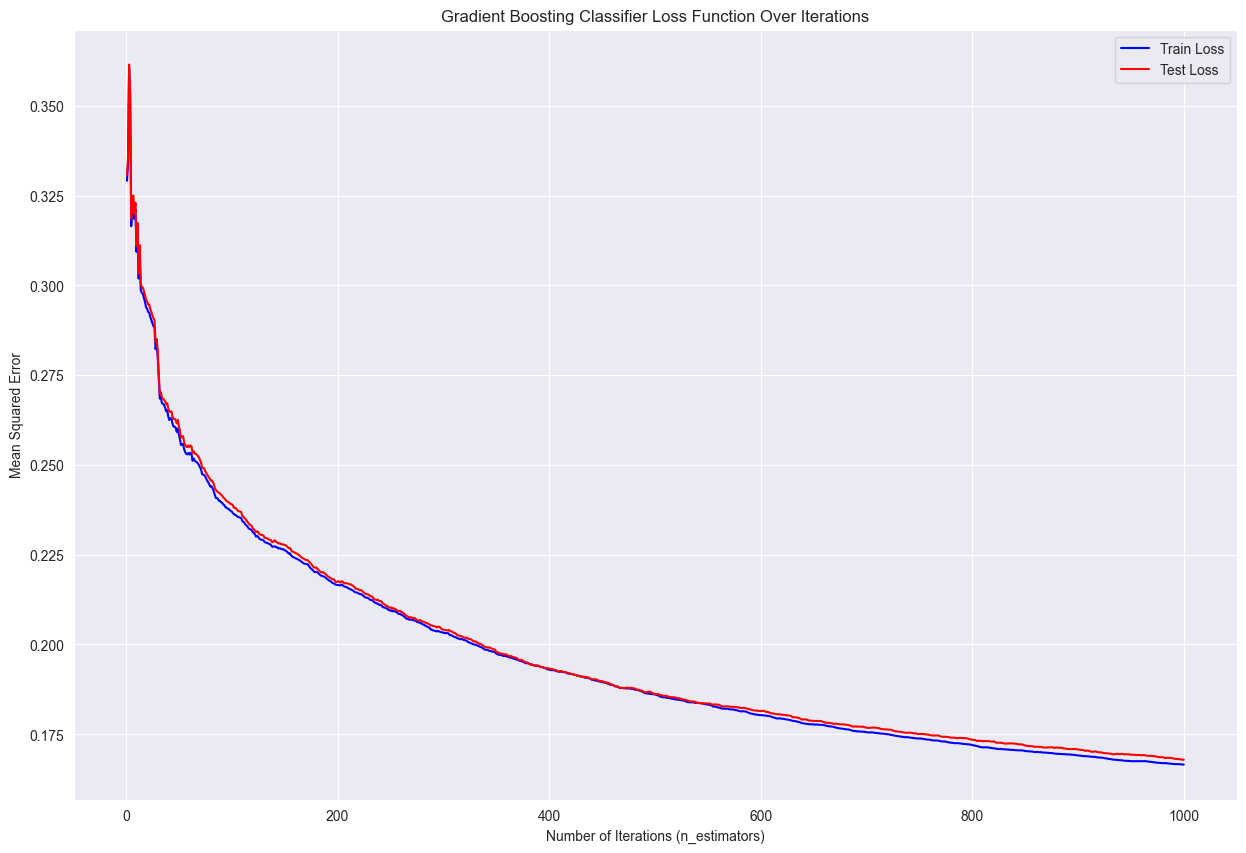

In [60]:
# Hier geht es schon is hyperparameter tuning, außerdem will ich mir anschauen ob ein Overfitting vorhanden ist.  

# Train loss überwachen 
train_loss = []
for y_pred in gb_model.staged_predict(X_train):
    loss = mean_squared_error(y_train, y_pred)
    train_loss.append(loss)

# Test loss überwachen 
test_loss = []
for y_pred in gb_model.staged_predict(X_test):
    loss = mean_squared_error(y_test, y_pred)
    test_loss.append(loss)

# loss über die Iterationen plotten
plt.figure(figsize=(15, 10))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train Loss", color='blue')
plt.plot(range(1, len(test_loss) + 1), test_loss, label="Test Loss", color='red')
plt.title("Gradient Boosting Classifier Loss Function Over Iterations")
plt.xlabel("Number of Iterations (n_estimators)")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()


## Auswertungen

Log Loss: 0.3081
AUC: 0.8419


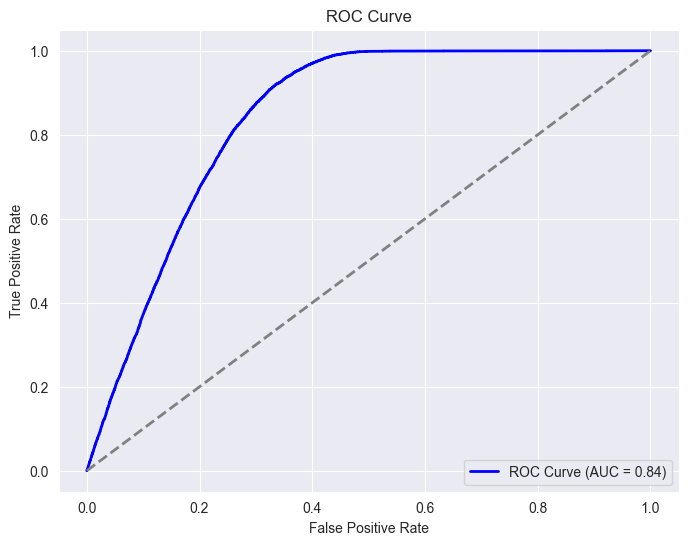

In [61]:
# Vorhersagewahrscheinlichkeiten für die Klasse 1 (positive Klasse)
y_pred_prob = gb_model.predict_proba(X_test)[:, 1]
# Log Loss
logloss = log_loss(y_test, y_pred_prob)

# AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Log Loss: {logloss:.4f}")
print(f"AUC: {auc:.4f}")

# Berechnung der FPR und TPR für verschiedene Schwellenwerte
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)


# Plotten der ROC-Kurve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonale Linie für zufällige Klassifikation
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Feature Einfluss

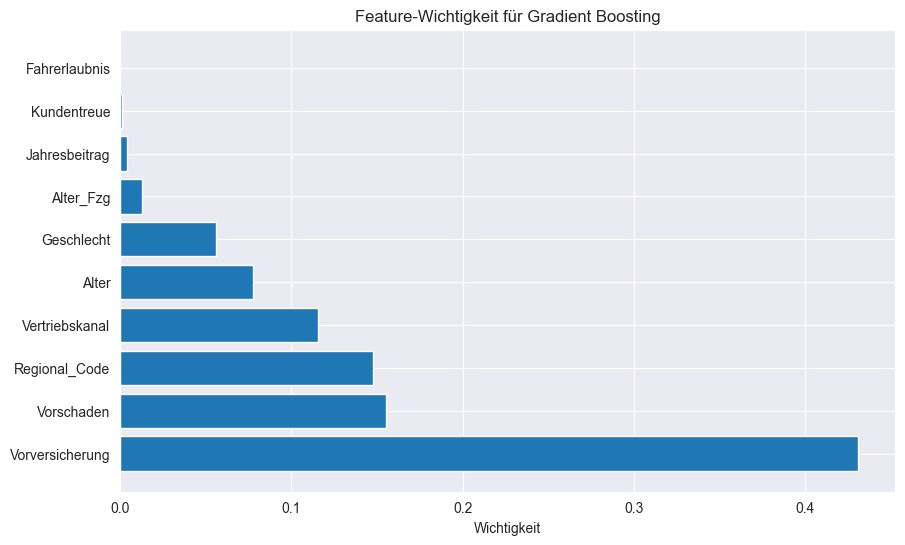

In [62]:
# Feature-Wichtigkeiten extrahieren
feature_importances = gb_model.feature_importances_

# Feature-Wichtigkeiten sortieren und anzeigen
indices = np.argsort(feature_importances)[::-1]

# Plot der Feature-Wichtigkeiten
plt.figure(figsize=(10, 6))
plt.title("Feature-Wichtigkeit für Gradient Boosting")
plt.barh(range(X.shape[1]), feature_importances[indices], align="center")
plt.yticks(range(X.shape[1]), [X.columns[i] for i in indices])
plt.xlabel("Wichtigkeit")
plt.show()


## Weiters Vorgehen: 

### Fehler gewichtung einstellen, um den Recall auf 1 zu verbessern, es könnten Fehler auf klasse eins schwerer gewichtet werden als fehler auf klasse 0
### ebenso könnte das Einstellen des Thresholds den Recall auf 1 verbessern
 
### um grundlegende Verbessereungen zu erreichen könnte weitere Zeit in das Feature Engeneering gesteckt werden
### bei fast 90% Accuracy und der einer AUC von 0,97 ist das model allerdings schon in der Lage sehr gute entscheidungen zu Treffen
### es Sollte aufjeden Fall noch zeit in das Hyperparameter Tuning gesteckt werden, da hier mit den vorhanden Features noch nicht das volle Potential ausgeschöpft ist 